# U.S. Presidential Elections and Market Volatility: Foundations for Final Analysis 5

**Duke University – Fuqua School of Business**  
**MQM Finance Capstone Project | Team 56**  
**Team Members**: Weicheng Wang, Qi Deng, Jiaying Sun, Omair Khan, Pavan Meka Kumar

---

This notebook presents a systematic framework to analyze how U.S. presidential elections from 2000 to 2024 influence financial market volatility. Through four complementary analyses, we examine long-term volatility trends, volatility by election phase, abnormal shocks using ARIMA and GARCH models, and quantify political risk using a structured scoring system. Each analysis contributes to building a data-driven foundation for interpreting political uncertainty and its transmission into asset class volatility.

The outputs here will support our **Final Analysis 5**, conducted in a separate notebook, which integrates historical insights with scenario-based asset allocation recommendations for a hypothetical client portfolio under election-linked uncertainty.


## Analysis 1: Long-Term Volatility Patterns Across Election Cycles

In this analysis, we examine how the volatility of major financial indexes evolves over successive U.S. presidential election cycles (2000–2024). Using the finalized volatility dataset, we compute the **monthly variance** of each index within each 4-year election cycle and convert these into normalized weights to understand their relative contributions to market uncertainty.

Mathematically, for each index \( i \) in cycle \( c \), we first compute the monthly mean time series x_i,t and then calculate the variance:

$$
\sigma_{i,c}^2 = \text{Var} \left( \frac{1}{M} \sum_{t=1}^{M} x_{i,t} \right)
$$

Next, we derive the **normalized weight** of each index based on its share of total variance in that cycle:

$$
w_{i,c} = \frac{\sigma_{i,c}^2}{\sum_j \sigma_{j,c}^2}
$$

These weights help us assess which indexes dominate volatility in each cycle and how their influence shifts across time. This provides insight into long-term market sensitivity to different asset classes during politically uncertain periods.


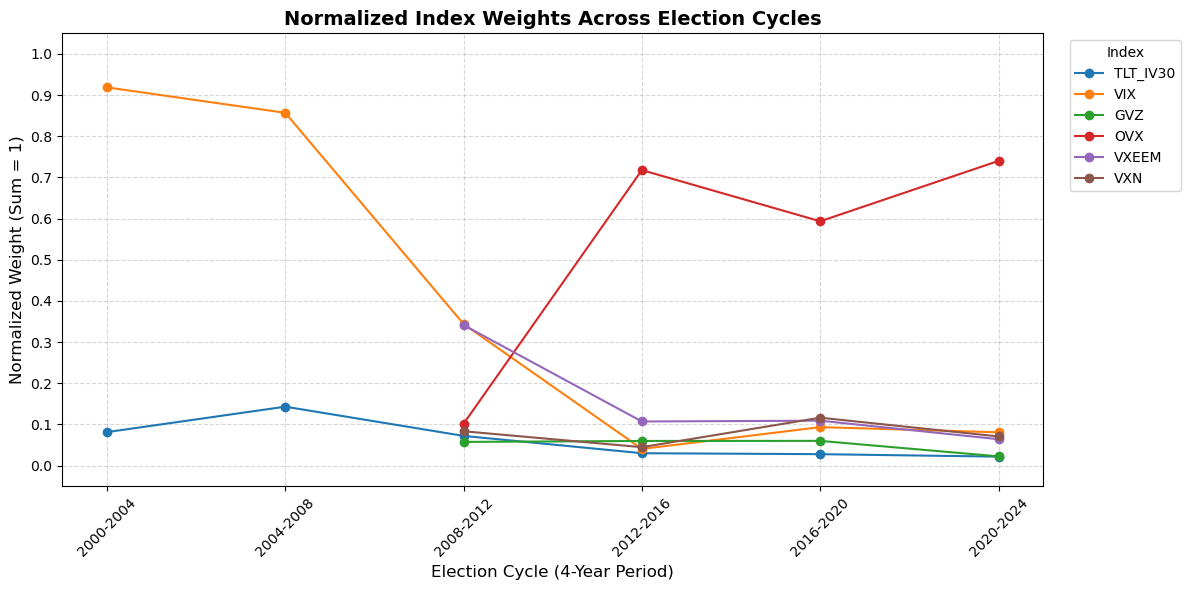

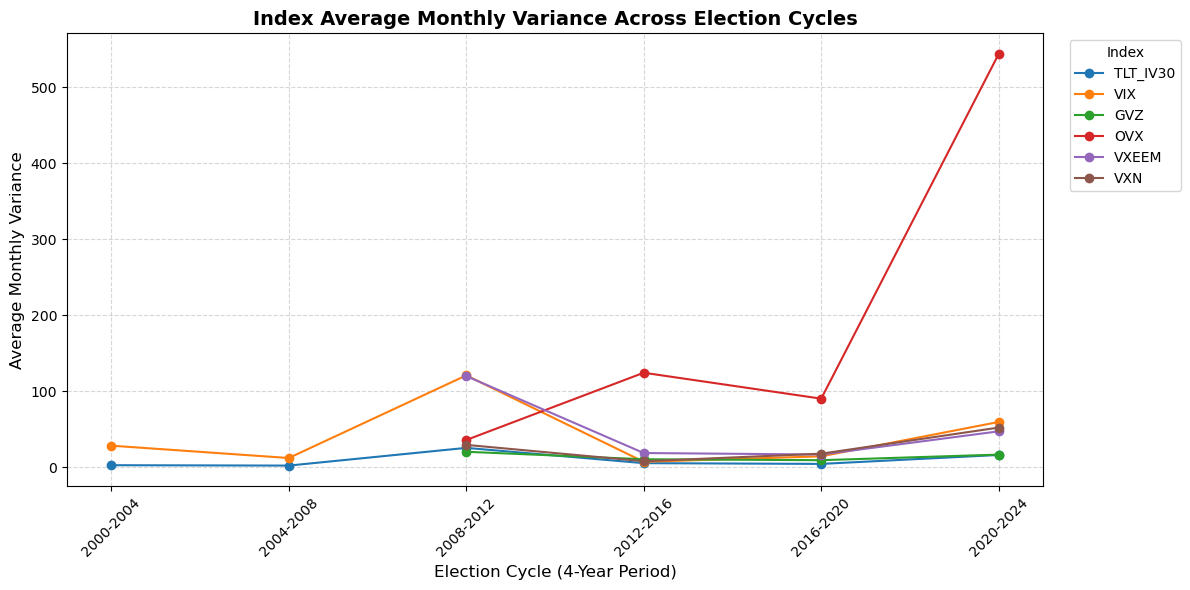

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# === Load final vol index data ===
file_path = '/Users/weichengwang/Desktop/DukeMQMBA_CourseFiles/[5] Spring 2 Term (3:17:2025 - 4:30:2025)/Capstone Project/Finalized_Data_Analysis_wk5/b_DataAnalysis/Master_Volatility_Index_Daily.csv'
df = pd.read_csv(file_path)
df['DATE'] = pd.to_datetime(df['DATE'])

# === Filter to election analysis period ===
df = df[(df['DATE'] >= '2000-01-01') & (df['DATE'] <= '2025-04-17')]

# === Define 4-year election cycles ===
def assign_cycle(date):
    year = date.year
    if year < 2004:
        return '2000-2004'
    elif year < 2008:
        return '2004-2008'
    elif year < 2012:
        return '2008-2012'
    elif year < 2016:
        return '2012-2016'
    elif year < 2020:
        return '2016-2020'
    elif year < 2024:
        return '2020-2024'
    else:
        return None  # Exclude 2024–2028

df['Cycle'] = df['DATE'].apply(assign_cycle)
df = df[df['Cycle'].notnull()]  # Remove rows assigned to None

# === Calculate monthly variance per cycle per index ===
vol_cols = ['GVZ', 'OVX', 'TLT_IV30', 'VIX', 'VXEEM', 'VXN']
results = []

for cycle, group in df.groupby('Cycle'):
    index_vars = {}
    for col in vol_cols:
        try:
            if group[col].notna().sum() > 0:
                temp = group[['DATE', col]].dropna().set_index('DATE')
                monthly_mean = temp.resample('M').mean()
                index_vars[col] = monthly_mean.var().values[0]
        except Exception:
            pass  # Skip errors silently
    index_vars['Cycle'] = cycle
    results.append(index_vars)

df_cycle_var = pd.DataFrame(results).sort_values('Cycle')

# === Normalize into weights across indexes per cycle ===
df_weights = df_cycle_var.set_index('Cycle')
df_weights_norm = df_weights.div(df_weights.sum(axis=1), axis=0)

# === Plot 1: Normalized Index Weights ===
plt.figure(figsize=(12, 6))
for col in df_weights_norm.columns:
    plt.plot(df_weights_norm.index, df_weights_norm[col], marker='o', label=col)

plt.title('Normalized Index Weights Across Election Cycles', fontsize=14, fontweight='bold')
plt.xlabel('Election Cycle (4-Year Period)', fontsize=12)
plt.ylabel('Normalized Weight (Sum = 1)', fontsize=12)
plt.ylim(-0.05, 1.05)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Index', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.savefig('/Users/weichengwang/Desktop/DukeMQMBA_CourseFiles/[5] Spring 2 Term (3:17:2025 - 4:30:2025)/Capstone Project/Python_Data_Analysis/IndexWeights_ElectionCycles_Revised.png', dpi=300)
plt.show()

# === Plot 2: Average Monthly Variance ===
plt.figure(figsize=(12, 6))
for col in df_weights.columns:
    plt.plot(df_weights.index, df_weights[col], marker='o', label=col)

plt.title('Index Average Monthly Variance Across Election Cycles', fontsize=14, fontweight='bold')
plt.xlabel('Election Cycle (4-Year Period)', fontsize=12)
plt.ylabel('Average Monthly Variance', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Index', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Analysis 2: Election-Phase Volatility and Risk Weight Dynamics

In this section, we analyze how financial market volatility varies across three critical U.S. presidential election phases: **Pre-Election**, **Election Month**, and **Post-Election**, from 2000 to 2024. Using daily data from six CBOE-based volatility indexes, we compute the average monthly variance for each index during these distinct windows. This helps identify how sensitive each index is to shifts in political uncertainty across time.

Mathematically, we calculate the average monthly variance of index \( i \) over period \( p \) during election year \( y \) as:

$$
\sigma_{i, y, p}^2 = \frac{1}{N_p} \sum_{m=1}^{N_p} \text{Var}_{m}(i)
$$

where:
- Var_m(i) is the variance of index \( i \) in month \( m \),
- Np is the number of months in period \( p \) (e.g., Pre-Election = 3 months).

Next, to assess relative volatility impact, we normalize each index’s variance within a given year-period:

$$
w_{i, y, p} = \frac{\sigma_{i, y, p}^2}{\sum_j \sigma_{j, y, p}^2}
$$

These **normalized weights** reflect the proportion of volatility risk each index contributes during each phase. The plots visualize these dynamics across election years, offering insights into how different asset classes respond to political cycles and where volatility risk is most concentrated.


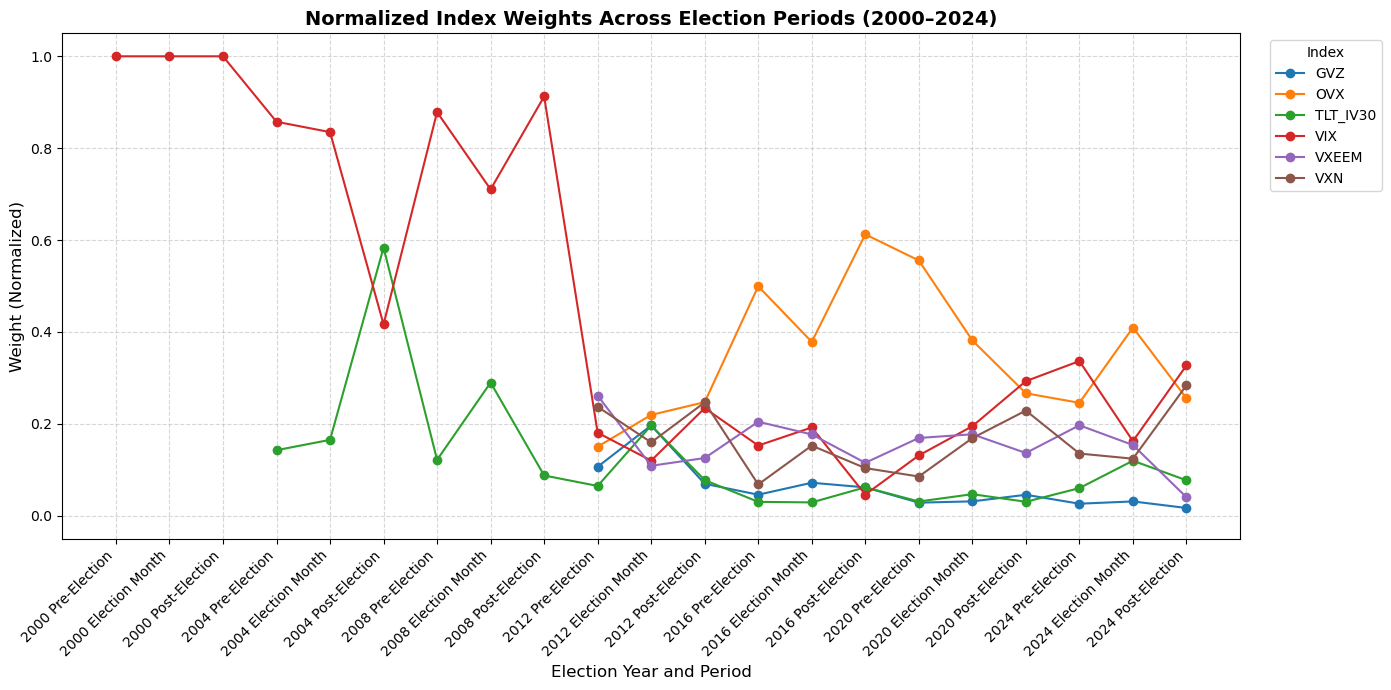

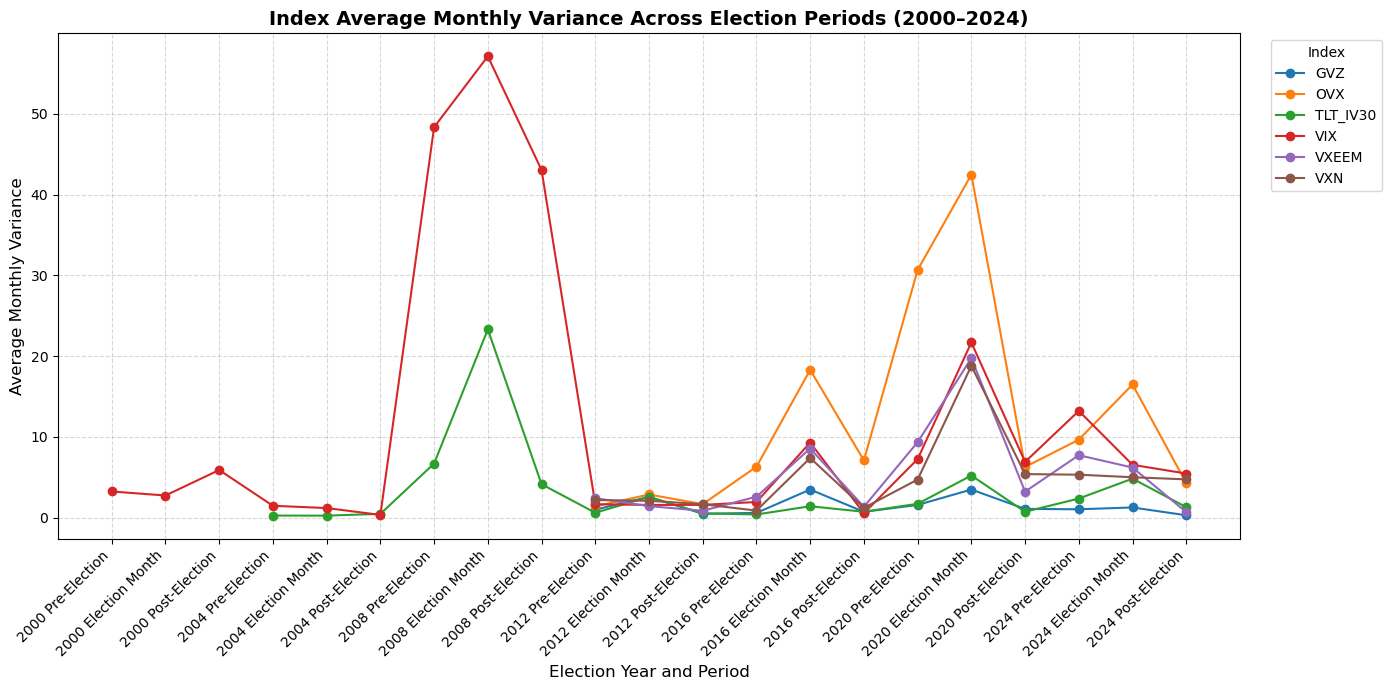

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
from pandas.api.types import CategoricalDtype

# Suppress warnings
warnings.filterwarnings("ignore")

# === File path ===
file_path = '/Users/weichengwang/Desktop/DukeMQMBA_CourseFiles/[5] Spring 2 Term (3:17:2025 - 4:30:2025)/Capstone Project/Finalized_Data_Analysis_wk5/b_DataAnalysis/Master_Volatility_Index_Daily.csv'

# === Load data ===
df = pd.read_csv(file_path)
df['DATE'] = pd.to_datetime(df['DATE'])

# === Define election periods ===
election_years = [2000, 2004, 2008, 2012, 2016, 2020, 2024]
periods = {
    'Pre-Election': lambda year: (f'{year}-08-01', f'{year}-10-31'),
    'Election Month': lambda year: (f'{year}-11-01', f'{year}-11-30'),
    'Post-Election': lambda year: (f'{year}-12-01', f'{year + 1}-01-31')
}

# === Index columns ===
index_cols = ['GVZ', 'OVX', 'TLT_IV30', 'VIX', 'VXEEM', 'VXN']
results = []

# === Compute average monthly variance by period and election year ===
for year in election_years:
    for period_name, date_range_fn in periods.items():
        start_date, end_date = date_range_fn(year)
        mask = (df['DATE'] >= start_date) & (df['DATE'] <= end_date)
        period_df = df.loc[mask].copy()
        period_df['Month'] = period_df['DATE'].dt.to_period('M')

        for index in index_cols:
            if index in period_df.columns:
                monthly_data = period_df[['Month', index]].dropna()
                monthly_var = monthly_data.groupby('Month')[index].var().mean()
                results.append({
                    'Election_Year': year,
                    'Period': period_name,
                    'Index': index,
                    'Avg_Monthly_Variance': monthly_var
                })

# === Create DataFrame ===
results_df = pd.DataFrame(results)

# === Normalize weights ===
results_df['Weight'] = results_df.groupby(['Election_Year', 'Period'])['Avg_Monthly_Variance'].transform(
    lambda x: x / x.sum()
)

# === Create 'Election_Year_Period' column ===
results_df['Election_Year_Period'] = results_df['Election_Year'].astype(str) + ' ' + results_df['Period']

# === Define custom order for 'Election_Year_Period' ===
period_order = ['Pre-Election', 'Election Month', 'Post-Election']
custom_order = [f"{year} {period}" for year in election_years for period in period_order]
cat_type = CategoricalDtype(categories=custom_order, ordered=True)
results_df['Election_Year_Period'] = results_df['Election_Year_Period'].astype(cat_type)

# === Sort DataFrame ===
results_df = results_df.sort_values('Election_Year_Period')

# === Pivot for plotting ===
pivot_weights = results_df.pivot(index='Election_Year_Period', columns='Index', values='Weight')
pivot_vars = results_df.pivot(index='Election_Year_Period', columns='Index', values='Avg_Monthly_Variance')

# === Visualization: Normalized Weights ===
plt.figure(figsize=(14, 7))
for col in pivot_weights.columns:
    plt.plot(pivot_weights.index, pivot_weights[col], marker='o', label=col)

plt.title('Normalized Index Weights Across Election Periods (2000–2024)', fontsize=14, fontweight='bold')
plt.xlabel('Election Year and Period', fontsize=12)
plt.ylabel('Weight (Normalized)', fontsize=12)
plt.ylim(-0.05, 1.05)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Index', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# === Visualization: Avg Monthly Variance ===
plt.figure(figsize=(14, 7))
for col in pivot_vars.columns:
    plt.plot(pivot_vars.index, pivot_vars[col], marker='o', label=col)

plt.title('Index Average Monthly Variance Across Election Periods (2000–2024)', fontsize=14, fontweight='bold')
plt.xlabel('Election Year and Period', fontsize=12)
plt.ylabel('Average Monthly Variance', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Index', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Analysis 3: Enhanced Event Study Using GARCH and ARIMA Models

In this analysis, we quantify how financial volatility indexes respond to U.S. presidential elections using **pre-election-only data** to avoid lookahead bias. For each index and election year (2000–2024), we define a **training window** from August 1 to October 31 (Pre-Election) and evaluate predictions on the December–January (Post-Election) window. This setup ensures that model forecasts are uninfluenced by the election outcome itself.

We apply two models to the pre-election data:

- **ARIMA(1,0,0)** to forecast post-election levels  
- **GARCH(1,1)** to forecast post-election conditional volatility  

The abnormal impact is computed as the difference between actual and predicted values:

$$
\text{ARIMA Abnormal}_t = Y_t^\text{actual} - Y_t^\text{forecast}
$$

$$
\text{GARCH Abnormal Std} = \sigma_\text{post}^\text{actual} - \hat{\sigma}_\text{post}^\text{forecast}
$$

Statistical significance is assessed using a **one-sample t-test** on these abnormal movements. By comparing both ARIMA and GARCH outputs, we capture both **mean shifts** and **volatility shocks** attributable to election uncertainty.

In [26]:
import os
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

# === File path ===
file_path = '/Users/weichengwang/Desktop/DukeMQMBA_CourseFiles/[5] Spring 2 Term (3:17:2025 - 4:30:2025)/Capstone Project/Finalized_Data_Analysis_wk5/b_DataAnalysis/Master_Volatility_Index_Daily.csv'
df_all = pd.read_csv(file_path)
df_all['DATE'] = pd.to_datetime(df_all['DATE'])

# === Election Dates ===
election_years = {
    2000: '2000-11-07',
    2004: '2004-11-02',
    2008: '2008-11-04',
    2012: '2012-11-06',
    2016: '2016-11-08',
    2020: '2020-11-03',
    2024: '2024-11-05'
}

# === Index columns to analyze ===
index_cols = ['GVZ', 'OVX', 'TLT_IV30', 'VIX', 'VXEEM', 'VXN']

# === Containers ===
garch_results = []
arima_results = []

# === Loop over indexes and elections ===
for col in index_cols:
    for year, elec_date_str in election_years.items():
        elec_date = pd.to_datetime(elec_date_str)
        pre_start = elec_date - pd.DateOffset(months=3)
        pre_end = elec_date - pd.DateOffset(days=1)
        post_start = elec_date + pd.DateOffset(days=1)
        post_end = elec_date + pd.DateOffset(months=2)

        df = df_all[['DATE', col]].dropna()
        df_pre = df[(df['DATE'] >= pre_start) & (df['DATE'] <= pre_end)].copy()
        df_post = df[(df['DATE'] >= post_start) & (df['DATE'] <= post_end)].copy()

        if len(df_pre) < 30 or len(df_post) < 5:
            continue

        # === GARCH ===
        returns_pre = df_pre[col].pct_change().dropna() * 100
        returns_post = df_post[col].pct_change().dropna() * 100
        actual_std = returns_post.std()

        try:
            garch_model = arch_model(returns_pre, vol='GARCH', p=1, q=1).fit(disp='off')
            garch_forecast = garch_model.forecast(horizon=len(returns_post), reindex=False)
            pred_var = garch_forecast.variance.values[-1]
            pred_std = np.sqrt(pred_var)
            sim_abn = actual_std - np.random.normal(loc=pred_std.mean(), scale=pred_std.std(), size=1000)
            t_stat, p_val = ttest_1samp(sim_abn, 0.0)
            garch_results.append({
                'Model': 'GARCH',
                'Index': col,
                'Election_Year': year,
                'Pre_Start': pre_start.date(),
                'Post_End': post_end.date(),
                'Predicted': round(pred_std.mean(), 4),
                'Actual': round(actual_std, 4),
                'Abnormal': round(actual_std - pred_std.mean(), 4),
                't_stat': round(t_stat, 4),
                'p_value': round(p_val, 4),
                'Significant_@5%': p_val < 0.05
            })
        except:
            pass

        # === ARIMA ===
        try:
            arima_model = ARIMA(df_pre[col], order=(1, 0, 0)).fit()
            forecast = arima_model.forecast(steps=len(df_post))
            df_post['Predicted'] = forecast.values
            df_post['Abnormal'] = df_post[col].values - df_post['Predicted']
            t_stat, p_val = ttest_1samp(df_post['Abnormal'].dropna(), 0)
            arima_results.append({
                'Model': 'ARIMA',
                'Index': col,
                'Election_Year': year,
                'Pre_Start': pre_start.date(),
                'Post_End': post_end.date(),
                'Predicted': round(df_post['Predicted'].mean(), 4),
                'Actual': round(df_post[col].mean(), 4),
                'Abnormal': round(df_post['Abnormal'].mean(), 4),
                't_stat': round(t_stat, 4),
                'p_value': round(p_val, 4),
                'Significant_@5%': p_val < 0.05
            })
        except:
            pass

# === Combine and Save ===
df_combined = pd.DataFrame(garch_results + arima_results)
save_path = os.path.join(os.path.dirname(file_path), 'Combined_Event_Study_ARIMA_GARCH.csv')
df_combined.to_csv(save_path, index=False)

# === Display Results in Notebook ===
import IPython.display as disp

# Separate GARCH and ARIMA results for easier viewing
df_garch = df_combined[df_combined['Model'] == 'GARCH'].sort_values(by=['Election_Year', 'Index'])
df_arima = df_combined[df_combined['Model'] == 'ARIMA'].sort_values(by=['Election_Year', 'Index'])

print("=== GARCH Event Study Results ===")
disp.display(df_garch)

print("\n=== ARIMA Event Study Results ===")
disp.display(df_arima)

=== GARCH Event Study Results ===


,Model,Index,Election_Year,Pre_Start,Post_End,Predicted,Actual,Abnormal,t_stat,p_value,Significant_@5%
14,GARCH,VIX,2000,2000-08-07,2001-01-07,6.0798,5.2682,-0.8116,-8.787520e+01,0.0,True
8,GARCH,TLT_IV30,2004,2004-08-02,2005-01-02,10.9103,4.7873,-6.1230,-1.959522e+02,0.0,True
15,GARCH,VIX,2004,2004-08-02,2005-01-02,5.5723,5.2534,-0.3189,-1.831694e+02,0.0,True
9,GARCH,TLT_IV30,2008,2008-08-04,2009-01-04,11.3773,7.7256,-3.6518,-8.532052e+02,0.0,True
16,GARCH,VIX,2008,2008-08-04,2009-01-04,9.9819,5.9806,-4.0013,-2.661015e+02,0.0,True
0,GARCH,GVZ,2012,2012-08-06,2013-01-06,3.7691,5.9699,2.2008,5.271000e+02,0.0,True
4,GARCH,OVX,2012,2012-08-06,2013-01-06,3.3080,2.3918,-0.9162,-1.852380e+03,0.0,True
10,GARCH,TLT_IV30,2012,2012-08-06,2013-01-06,3.6383,3.1631,-0.4752,-1.905150e+02,0.0,True
17,GARCH,VIX,2012,2012-08-06,2013-01-06,5.2788,5.8143,0.5355,9.927240e+01,0.0,True
21,GARCH,VXEEM,2012,2012-08-06,2013-01-06,4.2528,3.4925,-0.7604,-3.238401e+02,0.0,True



=== ARIMA Event Study Results ===


,Model,Index,Election_Year,Pre_Start,Post_End,Predicted,Actual,Abnormal,t_stat,p_value,Significant_@5%
43,ARIMA,VIX,2000,2000-08-07,2001-01-07,22.7470,26.9439,4.1969,13.1696,0.0000,True
37,ARIMA,TLT_IV30,2004,2004-08-02,2005-01-02,10.0484,9.9530,-0.0954,-0.9951,0.3257,False
44,ARIMA,VIX,2004,2004-08-02,2005-01-02,15.6225,12.8202,-2.8023,-26.3463,0.0000,True
38,ARIMA,TLT_IV30,2008,2008-08-04,2009-01-04,16.0971,28.9260,12.8289,12.8549,0.0000,True
45,ARIMA,VIX,2008,2008-08-04,2009-01-04,51.0291,57.1728,6.1437,4.8088,0.0000,True
29,ARIMA,GVZ,2012,2012-08-06,2013-01-06,16.7683,14.0327,-2.7356,-18.5849,0.0000,True
33,ARIMA,OVX,2012,2012-08-06,2013-01-06,32.6897,29.3850,-3.3047,-12.5113,0.0000,True
39,ARIMA,TLT_IV30,2012,2012-08-06,2013-01-06,15.6383,13.0765,-2.5618,-28.4751,0.0000,True
46,ARIMA,VIX,2012,2012-08-06,2013-01-06,16.3832,16.8142,0.4310,1.6972,0.0976,False
50,ARIMA,VXEEM,2012,2012-08-06,2013-01-06,23.1433,21.8201,-1.3232,-6.3008,0.0000,True


## Analysis 4: Quantifying U.S. Presidential Election Characteristics with a Rating System  
**A Structured Assessment of Political, Electoral, and Crisis-Driven Factors from 2000 to 2024**  
**MQM Finance Capstone Project | Team 56: Weicheng Wang, Qi Deng, Jiaying Sun, Omair Khan, Pavan Meka Kumar**

This analysis converts qualitative political events into quantitative indicators to capture electoral volatility. For each U.S. presidential election from 2000 to 2024, we assign binary or ordinal values to reflect the winning party, incumbency outcome, whether the election was contested, party control shifts, electoral mandate strength, presidential term status, and crisis context.

This structured encoding feeds into our downstream forecasting model by allowing political scenarios to be numerically interpreted and linked to historical patterns in market volatility.

### Variables and Scoring Framework

- **Winning_Party**: Republican = 0, Democrat = 1  
- **Incumbent_Reelected**: 1 if incumbent won re-election, else 0  
- **Contested_Delayed**: 1 if election was legally contested or results delayed  
- **Party_Switch**: 1 if presidency changed party  
- **First_Term_President**: 1 if winner entered first term  
- **Crisis**: 1 if major economic/pandemic/geopolitical crisis occurred during the election year  

### Electoral Mandate Strength – Score Formula

We transform the electoral college result into a five-level ordinal score using the following binning scheme:

$$
\text{Electoral Score} = 
\begin{cases}
1 & \text{if } EV < 200 \\
2 & \text{if } 200 \leq EV < 251 \\
3 & \text{if } 251 \leq EV < 301 \\
4 & \text{if } 301 \leq EV < 351 \\
5 & \text{if } EV \geq 351 \\
\end{cases}
$$

This scoring system reflects the perceived strength of mandate, where a higher score implies broader support and potentially less transition risk.

All input values for 2000–2024 are selected based on historical outcomes (e.g., Supreme Court rulings, official Electoral College results, concession timing, or public health crises). This provides a robust political feature set for scenario modeling and volatility analysis in subsequent steps.


In [30]:
import pandas as pd

elections_data = [
    {
        "Year": 2000,
        "Winning_Party": 0,          # Bush (Republican) won.
        "Incumbent_Reelected": 0,    # Clinton (Democrat) was term-limited.
        "Contested_Delayed": 1,      # Supreme Court ruling delayed final result.
        "Party_Switch": 1,           # Party switched from Democrat to Republican.
        "Electoral_Votes": 271,      # Bush secured 271 EVs.
        "Electoral_Score": 3,        # 271 EVs falls in 251–300 → score = 3.
        "First_Term_President": 1,   # Bush's first term.
        "Crisis": 0                  # No major national crisis in 2000.
    },
    {
        "Year": 2004,
        "Winning_Party": 0,          # Bush (Republican) re-elected.
        "Incumbent_Reelected": 1,    # Bush won a second term.
        "Contested_Delayed": 0,      # No contest or delay in results.
        "Party_Switch": 0,           # No party switch; Republicans stayed in power.
        "Electoral_Votes": 286,      # Bush earned 286 EVs.
        "Electoral_Score": 3,        # 286 EVs falls in 251–300 → score = 3.
        "First_Term_President": 0,   # Bush already served first term.
        "Crisis": 0                  # No major economic or global crisis in 2004.
    },
    {
        "Year": 2008,
        "Winning_Party": 1,          # Obama (Democrat) won.
        "Incumbent_Reelected": 0,    # Bush (Republican) was term-limited.
        "Contested_Delayed": 0,      # Clear result with no delay.
        "Party_Switch": 1,           # Republican → Democrat transition.
        "Electoral_Votes": 365,      # Obama secured 365 EVs.
        "Electoral_Score": 5,        # 365 EVs ≥ 351 → score = 5.
        "First_Term_President": 1,   # Obama’s first presidential term.
        "Crisis": 1                  # 2008 global financial crisis ongoing.
    },
    {
        "Year": 2012,
        "Winning_Party": 1,          # Obama (Democrat) re-elected.
        "Incumbent_Reelected": 1,    # Obama won a second term.
        "Contested_Delayed": 0,      # No delay or dispute.
        "Party_Switch": 0,           # Democrats remained in office.
        "Electoral_Votes": 332,      # Obama earned 332 EVs.
        "Electoral_Score": 4,        # 301–350 → score = 4.
        "First_Term_President": 0,   # Obama was incumbent.
        "Crisis": 0                  # No major crisis at the time.
    },
    {
        "Year": 2016,
        "Winning_Party": 0,          # Trump (Republican) won.
        "Incumbent_Reelected": 0,    # Obama (Democrat) was term-limited.
        "Contested_Delayed": 0,      # No legal dispute over the result.
        "Party_Switch": 1,           # Democrat → Republican switch.
        "Electoral_Votes": 304,      # Trump won 304 EVs (after 2 faithless electors).
        "Electoral_Score": 4,        # 301–350 → score = 4.
        "First_Term_President": 1,   # Trump’s first time in office.
        "Crisis": 0                  # No national crisis in 2016.
    },
    {
        "Year": 2020,
        "Winning_Party": 1,          # Biden (Democrat) won.
        "Incumbent_Reelected": 0,    # Trump lost re-election.
        "Contested_Delayed": 1,      # Widely contested, with court cases and recounts.
        "Party_Switch": 1,           # Republican → Democrat transition.
        "Electoral_Votes": 306,      # Biden earned 306 EVs.
        "Electoral_Score": 4,        # 301–350 → score = 4.
        "First_Term_President": 1,   # Biden’s first presidential term.
        "Crisis": 1                  # Held during COVID-19 pandemic.
    },
    {
        "Year": 2024,
        "Winning_Party": 0,          # Trump (Republican) returned to office.
        "Incumbent_Reelected": 0,    # Harris (Democrat) lost; not an incumbent re-election.
        "Contested_Delayed": 0,      # No major legal contest; Harris conceded.
        "Party_Switch": 1,           # Democrat → Republican.
        "Electoral_Votes": 312,      # Trump won 312 EVs.
        "Electoral_Score": 4,        # 301–350 → score = 4.
        "First_Term_President": 0,   # Trump had previously served (2017–2021).
        "Crisis": 0                  # No major domestic or global crisis.
    }
]

df = pd.DataFrame(elections_data)
df.to_csv("US_Presidential_Elections_2000-2024.csv", index=False)